# Apply AI Superresolution to video - Train New Network from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

- See this video for explanation: https://www.youtube.com/watch?v=HEXLlqJQ7Oc


## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

New Network results
- Performs as well as VDSR qualitatively, need to check.
- using Div2K gives better results (needs low learning rate)
- try with L1 norm (less noise sensitive)
- add upscale in the middle to allow more flexibility - nn.ConvTranspose2d(in_channels=C, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
- add  with torch.no_grad():  to validation and prediction with the model to speed up computations.


To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader
- use mse but give more error to perception
- try reflection padding







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "NEWCNN7"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train New Network with kernel predictor input v3.1.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train New Network with kernel predictor input v3.1.ipynb
/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage,Normalize

from torchvision.transforms.functional import hflip

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
import fnmatch

In [10]:
from superres_utils import make_framelist3, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4

In [11]:
#loads 3 frames side by side in an image
def load_frame3(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]-1
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, imgm1 = cap.read()
        if ret==0:
            print("Error with:",instance)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
        ret, imgp1 = cap.read()
        if ret==0:
            print("Error with:",instance)
            
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        im_m1_rgb = cv2.cvtColor(imgm1, cv2.COLOR_BGR2RGB)
        im_p1_rgb = cv2.cvtColor(imgp1, cv2.COLOR_BGR2RGB)
        return [Image.fromarray(im_rgb), Image.fromarray(im_m1_rgb), Image.fromarray(im_p1_rgb)]
        
    elif instance["Type"] == "image":
        img = cv2.imread(path)
        # convert to PIL RGB
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return [Image.fromarray(im_rgb),Image.fromarray(im_rgb),Image.fromarray(im_rgb)]

In [ ]:
# get a list of all the data
#instances = make_framelist3("/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR",1)
instances = make_framelist3("/home/filip/SSD_link/superres/video_data/train_data",20)



In [ ]:
len(instances)

In [ ]:
#test the Multifuz transform
im_multiple=load_frame3(instances[100])
print(len(im_multiple))
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im_multiple[2])
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [ ]:
im_multiple[1]

In [ ]:
im_multiple[2]

In [ ]:
for i,q in enumerate(im_multiple):
    print( q.size)

In [12]:
class DatasetFromVideoFolder3(data.Dataset):
    def __init__(self, video_dir,crop_size,frame_sample_size=10,max_kernel=10,Flip_hor=True,
                 Rand_bright_contrast=True, input_transform =None,target_transform=None, match_exp="*.*", **camera_params):
        
        #  add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10

        super(DatasetFromVideoFolder3, self).__init__()
        self.video_frames = make_framelist3(video_dir,frame_sample_size,match_exp)
        
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.crop_size = crop_size
        self.max_kernel = max_kernel
        self.target_transform = target_transform
        self.camera_params = camera_params
        self.input_transform = input_transform
        
    def camera_transform(self,img_hr):
        
        # go through the parameters and simulate the camera
        width, height = img_hr.size
               
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        camera_specs = {}
        camera_specs["crop_size"] = np.int16(self.crop_size)
        
        camera_specs["center"] = np.int16((random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom)))
        
        camera_specs["scale"] = np.float32(random.uniform(0.5,2))
       
        
        #camera_specs["kernel_a"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        #camera_specs["kernel_b"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        
        camera_specs["kernel_a"] = np.int16(random.uniform(*self.camera_params["kernel_range"]))
        camera_specs["kernel_b"] = np.int16(random.uniform(*self.camera_params["kernel_range"]))
        camera_specs["quality"] = np.int16(random.uniform(*self.camera_params["quality_range"]))
        camera_specs["slope"] = np.float32(random.uniform(*self.camera_params["slope_range"]))
        camera_specs["radius"] = np.float32(random.uniform(*self.camera_params["radius_range"])*max(self.crop_size[0],self.crop_size[1]))
        
        #img_lr = Multifuz(**camera_specs)(img_hr)
        #return img_lr, camera_specs
        return camera_specs

    def __getitem__(self, index):
        img_multiple = load_frame3(self.video_frames[index])
        
        flip = random.randint(0,1)
        
        img_lr_list = []
        for i, img in enumerate(img_multiple):
            
            img_n = img
            if self.crop_size is not None:
                img_n = RescaleCrop(self.crop_size,self.max_kernel )(img_n)

            if self.Flip_hor and flip == 1:
                img_n = hflip(img_n)

            if self.Rand_bright_contrast:
                img_n = ColorJitter(brightness=.2, contrast=.2)(img_n)
        
        

            if i == 0 :
                camera_specs = self.camera_transform(img_n)
            # go through the parameters and simulate the camera
            img_lr = Multifuz(**camera_specs)(img_n)
            
        
            if self.input_transform:
                img_lr = self.input_transform(img_lr)

            if i == 0:
                if self.target_transform:
                    img_hr = self.target_transform(img_n)
            img_lr_list.append(img_lr)
            
        #print(camera_specs)
        return img_lr_list, img_hr, camera_specs

    def __len__(self):
        return len(self.video_frames)

In [13]:
def input_transform():        
    return Compose([        
        #Grayscale(num_output_channels=1),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])



def target_transform(crop_size):
    return Compose([
        #Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [15]:
#train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =30
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,16)
quality_range=(30,90) 
slope_range=(0.001, 0.1)
#radius_range=(0,0)  # make all one fuzziness
radius_range=(.1,.5)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=False

In [16]:
train_set = DatasetFromVideoFolder3(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [17]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(1,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [18]:
valid_set = DatasetFromVideoFolder3(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

In [19]:
from superres_utils import variance_of_laplacian

def show_batch(dataloader,size = 8, denormalize = True):

    inputs, outputs, camera_specs = next(iter(dataloader))
    
    if type(inputs) is list:
        columns = len(inputs) + 1
        rows = len(inputs[0])
    else:
        columns = 2
        rows = len(inputs)
        
    print("rows =",rows,"cols=",columns)
         
        
    #print(inputs.shape)
    #inputs = inputs.numpy().transpose((0, 2, 3, 1))
    #outputs = outputs.numpy().transpose((0, 2, 3, 1))
    #print(camera_specs)
    
    mn = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = columns*size, rows*size
    fig=plt.figure(figsize=(w, h))
    
    ax=[]
    
   
    for i in range(0, rows):
        
        for j in range(0, columns):
            if type(inputs) is list:
                if j< (columns - 1):
                    img = inputs[j][i].numpy().transpose((1,2,0))
                    if denormalize: img = img*std + mn
                else:
                    img = outputs[i].numpy().transpose((1,2,0))
                    
            else:
                if j == 0:
                    img = inputs[i].numpy().transpose((2,3,1))
                    if denormalize: img = img*std + mn
                else:
                    img = outputs[i].numpy().transpose((2,3,1))
                
            blur_measure = variance_of_laplacian((img*255).astype(np.uint8))
            ax.append(fig.add_subplot(rows, columns, rows*i + j +1))
            ax[-1].set_title('Blur: '+str(blur_measure))
            plt.imshow((img*255).astype(np.uint8),cmap='gray')
    plt.show()

rows = 4 cols= 4


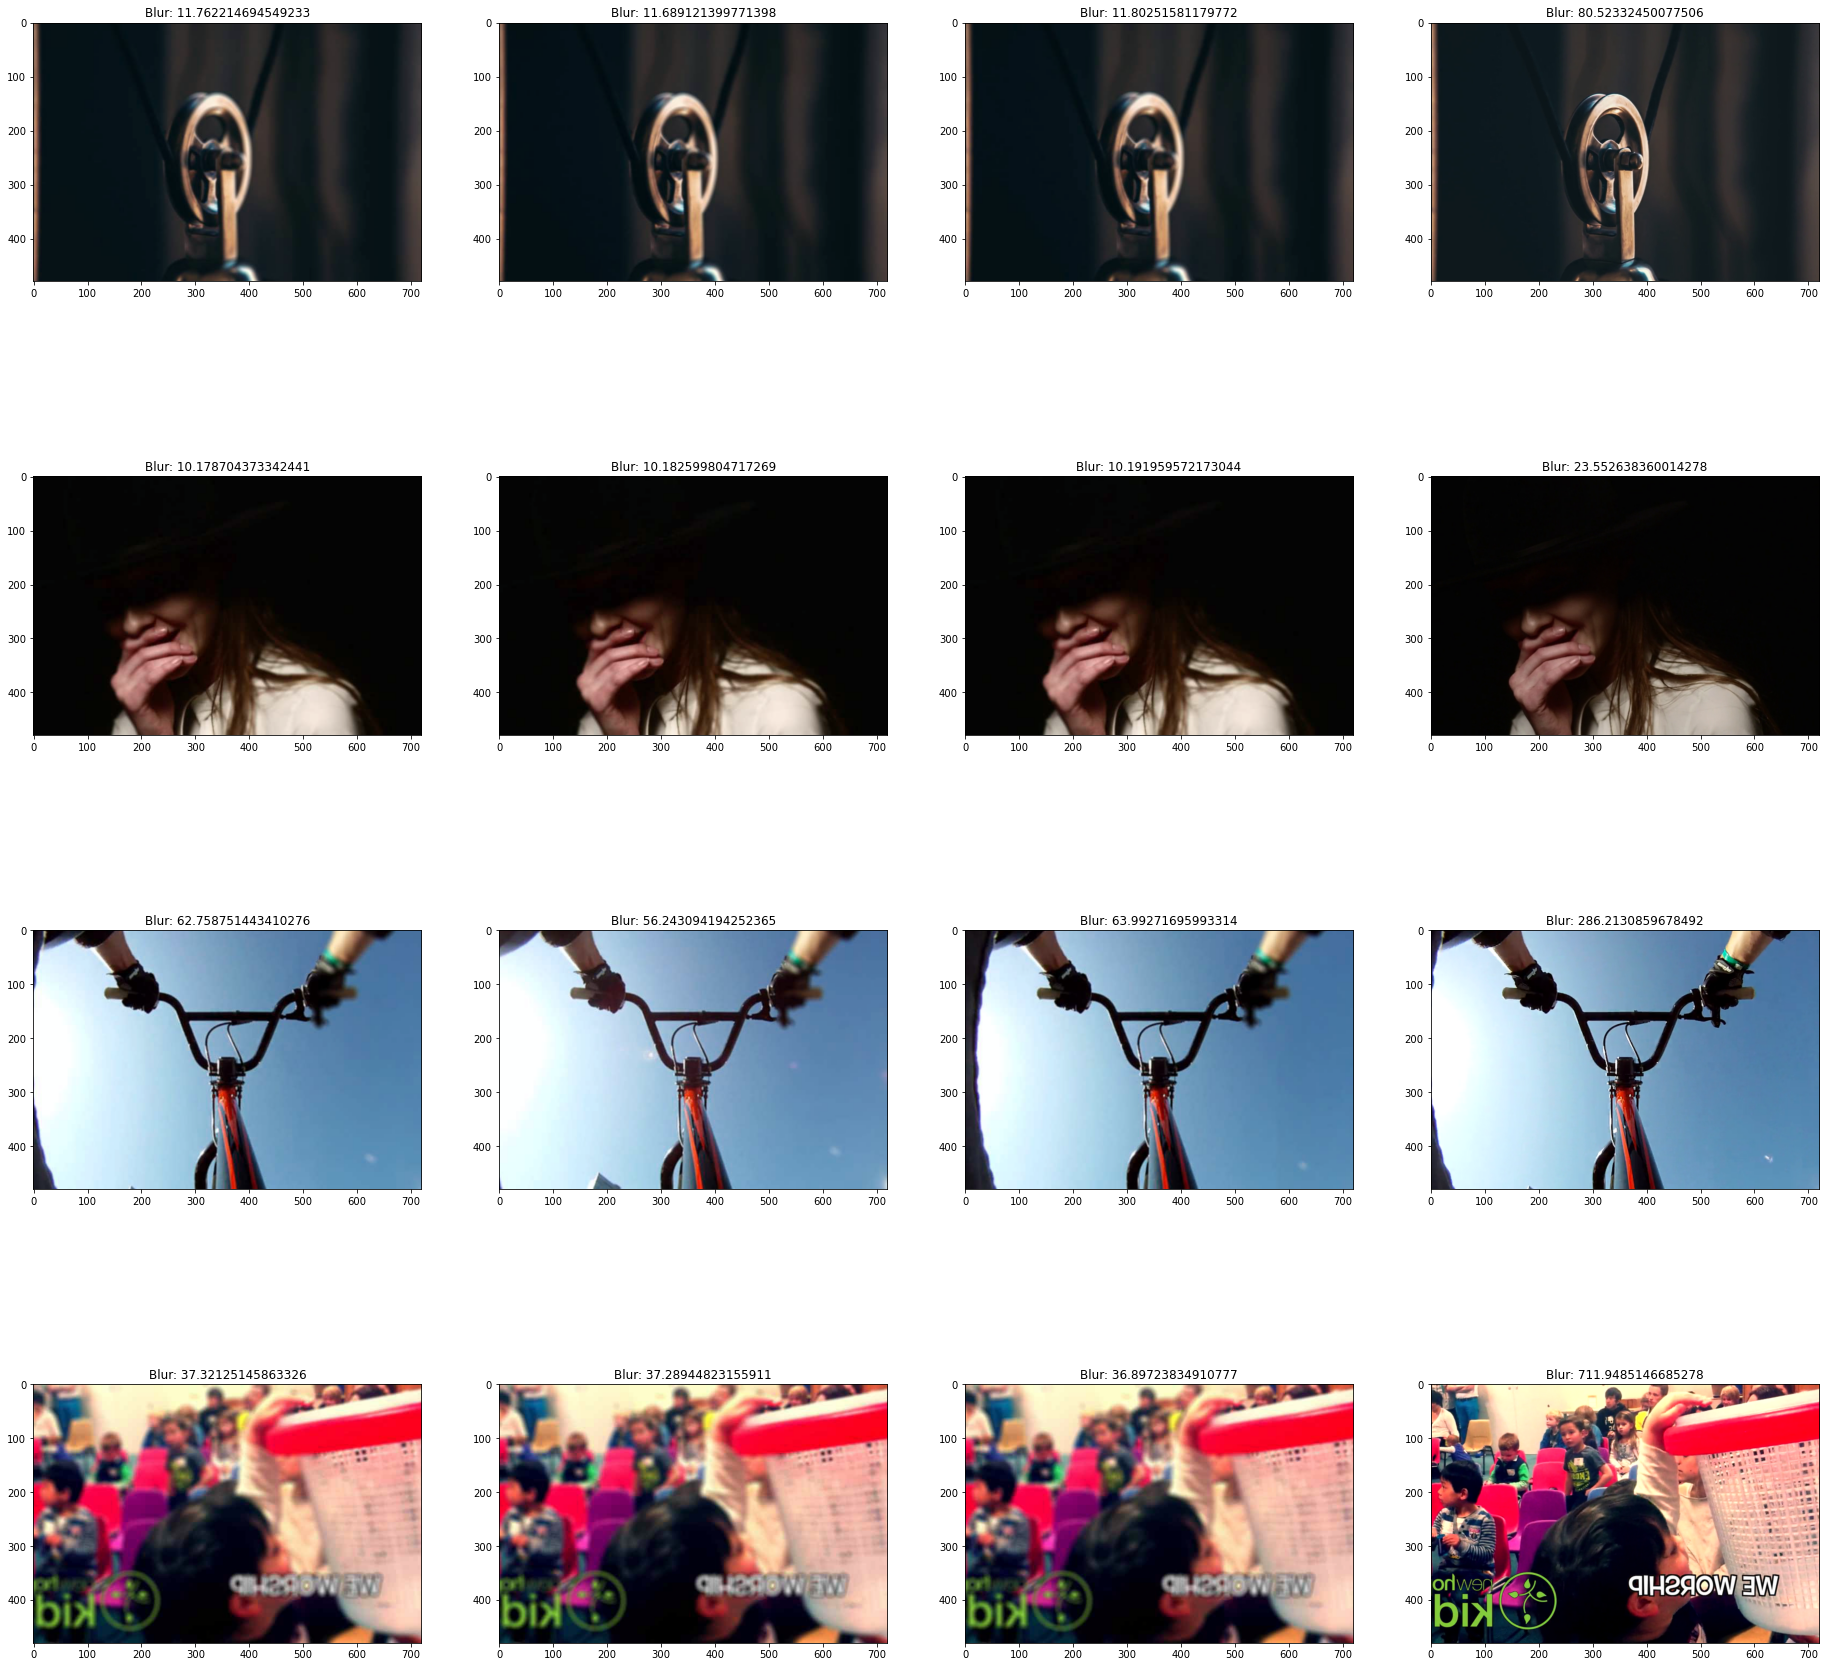

In [20]:
show_batch(training_data_loader,size =8)

rows = 4 cols= 4


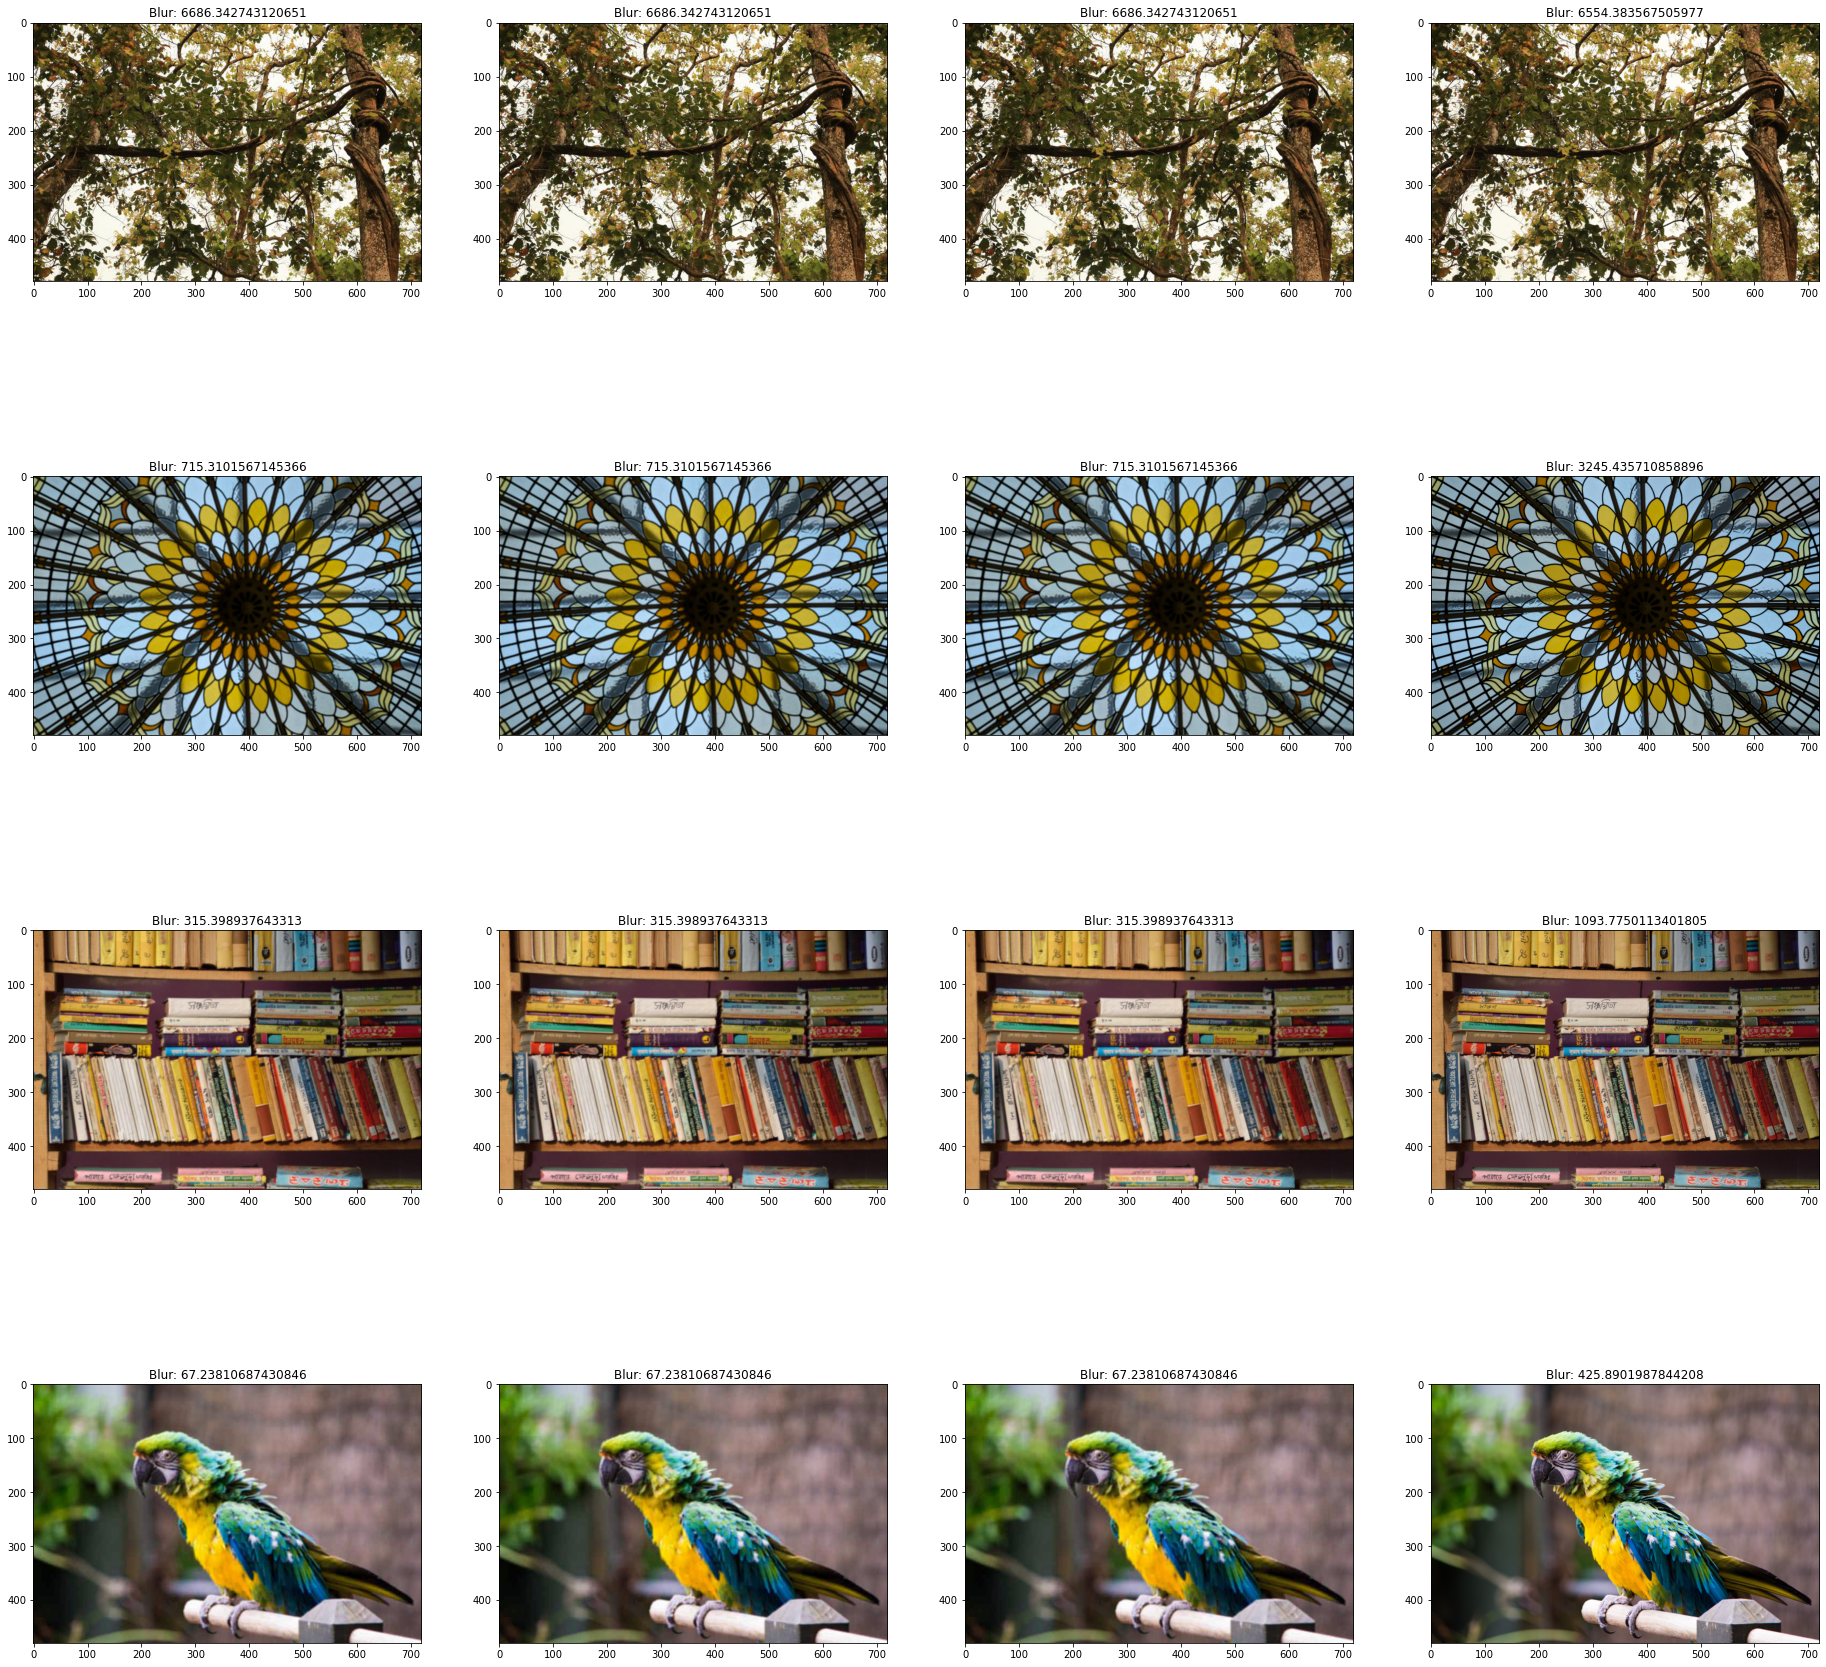

In [21]:
show_batch(valid_data_loader,size =8)

# NEW CNN

In [22]:
import torch.nn as nn

class NEWNet6(nn.Module):
    def __init__(self, c1, c2, c3):
        super(NEWNet6, self).__init__()   
        
        self.p1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU()
        )
        
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        )
        
        self.p3 = nn.Sequential(
            nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        
        
        )

        
        self.prelu = nn.PReLU()
        self.convf = nn.Conv2d(in_channels=c1, out_channels=3, kernel_size=3, stride=1, padding=1, bias=True)
        
                    
        
        
    def forward(self, x0,xm1,xp1, k):    
        
        residual = x0
       
        # add insert k as the 10 channel into x, which has 9 channels
        one_channel = x0[:,0,:,:].unsqueeze(1)  #use one channel as a template
        t1 = torch.ones_like(one_channel.permute(3,2,1,0))  #make a ones tensor like the channel
        res = k[:,0]*t1  # multiply by k, so that the batch spreads to the size of an image
        res = res.permute(3,2,1,0) # put back in proper order
        xk = torch.cat((x0,xm1,xp1,res), dim=1) #append the 10th channel
        
        
        
        
        xk = self.p1(xk)
        skip1 = xk
                        
        xk = self.p2(xk)
        xk = xk.add_(skip1)
        skip2 = xk
        
        xk = self.p3(xk)
        xk = xk.add_(skip2)
        
        xk = self.prelu(xk)
        xk = self.convf(xk)
        out = torch.add(xk,residual)
        return out

# build the model

In [24]:
model = torch.load("/media/SSD/superres/checkpoint/NEWCNN7_epoch_21.pth")["model"]
#model = NEWNet6(c1=64,c2=128, c3=1024)
model.cuda()

NEWNet6(
  (p1): Sequential(
    (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): PReLU(num_parameters=1)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
  )
  (p2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (p3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (prelu): PReLU(num_parameters=1)
  (convf): Conv2d(64, 

In [25]:
num_pixels = crop_size[0] * crop_size[1]

In [26]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [27]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(50 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [28]:
criterion = Pixel_Loss(num_pixels)
#criterion = nn.L1Loss(reduction = 'mean')
criterionk = nn.MSELoss(reduction = 'mean')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [29]:
init_lr = .0001
lr_step = 6
gradient_clip = 0.4
epoch_start = 22
epochs = 18

loops = 1

In [30]:

#optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=0)



In [ ]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [31]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [32]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [33]:
kmodel = torch.load("/media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_18.pth")["model"]

In [34]:
kmodel.cuda()
kmodel.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [35]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [36]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [40]:
def trainfp16(training_data_loader, optimizer, model,  kmodel, epoch,scaler, loops):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-epoch_start)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    
    cum_loss = 0
    ct=0  ##need to use a different variable.
    ct2=0

    pbar = tqdm(total=loops*len(training_data_loader))
    for loop_count in range(loops):  
        for iteration, batch in enumerate(training_data_loader, 1):
            inpt_list, target, camera_specs = batch[0], batch[1], batch[2]
            
            in0 = inpt_list[0].cuda()
            inm1 = inpt_list[1].cuda()
            inp1 = inpt_list[2].cuda()
            

            target = target.cuda()
            
            with torch.no_grad():
                with autocast():
                    k_pred = kmodel(in0)
            
            
            #k_target = (camera_specs["kernel_a"].float()).cuda()

            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output = model(in0,inm1,inp1,k_pred)
                loss = criterion(output, target)


            
            scaler.scale(loss).backward()
            #loss.backward() 

            # Unscales the gradients of optimizer's assigned params in-place
            #scaler.unscale_(optimizer)

            #nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 

            #optimizer.step()
            scaler.step(optimizer)

            if epoch>1:
                swa_model.update_parameters(model)

            # Updates the scale for next iteration.
            scaler.update()

            #scheduler.step()

            cum_loss = cum_loss + loss.data


            ct = ct +1 



            pbar.update(1)
    pbar.close()    
   
    print("Epoch Loss:", cum_loss/ct)        

In [41]:
def validatefp16(valid_data_loader, model, kmodel,  loop=10):

    model.eval()
    cum_loss2=0
    cum_loss1 = 0
    ct=0 
    
    with torch.no_grad():
        for r in trange(loop):
            for iteration, batch in enumerate(valid_data_loader, 1):
                inpt_list, target, camera_specs = batch[0], batch[1], batch[2]

                in0 = inpt_list[0].cuda()
                inm1 = inpt_list[1].cuda()
                inp1 = inpt_list[2].cuda()
                

                target = target.cuda()
                
                
                with autocast():
                    k_pred = kmodel(in0)
                
                k_target = (camera_specs["kernel_a"].float()).cuda()
                
                # Runs the forward pass with autocasting.
                with autocast():
                    output = model(in0, inm1, inp1,k_pred)
                    loss1 = criterion(output, target)
                    loss2 = criterionk(k_pred[:,0],k_target)

                #print(k_pred[:,0].shape, k_target.shape)
               
                cum_loss1 = cum_loss1 + loss1.data
                cum_loss2 = cum_loss2 + loss2.data

                ct = ct + 1 ## Used to be batch_size





        print("===> Epoch Validation Loss: {:.10f} , kernel pred RMSE {:.10f}".format(cum_loss1/ct,(cum_loss2/ct)**(.5)) )
    
    return (cum_loss1/ct).item()

In [43]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(epoch_start, epochs+epoch_start):
        trainfp16(training_data_loader, optimizer, model, kmodel, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model,kmodel,loop=10)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/4951 [00:00<?, ?it/s]

Start Time: 2020-11-22 05:31:14.398725
Epoch = 22, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.3228, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5747070312 , kernel pred RMSE 0.7574892640
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_22.pth
Start Time: 2020-11-22 07:23:26.574142
Epoch = 23, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.3188, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.6479492188 , kernel pred RMSE 0.7508355975
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_23.pth
Start Time: 2020-11-22 09:13:39.396424
Epoch = 24, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.3174, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5805664062 , kernel pred RMSE 0.7415295243
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_24.pth
Start Time: 2020-11-22 11:04:22.727030
Epoch = 25, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.3137, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5541992188 , kernel pred RMSE 0.7303190231
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_25.pth
Start Time: 2020-11-22 12:54:48.532715
Epoch = 26, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.3091, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5590820312 , kernel pred RMSE 0.7322973609
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_26.pth
Start Time: 2020-11-22 14:45:50.007718
Epoch = 27, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.3064, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5678710938 , kernel pred RMSE 0.7452404499
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_27.pth
Start Time: 2020-11-22 16:36:08.199481
Epoch = 28, lr = 3.1622776601683795e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2954, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5395507812 , kernel pred RMSE 0.7567386031
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_28.pth
Start Time: 2020-11-22 18:26:55.488746
Epoch = 29, lr = 3.1622776601683795e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2974, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5449218750 , kernel pred RMSE 0.7763888240
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_29.pth
Start Time: 2020-11-22 20:17:37.955319
Epoch = 30, lr = 3.1622776601683795e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2996, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5468750000 , kernel pred RMSE 0.7746979594
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_30.pth
Start Time: 2020-11-22 22:08:03.689446
Epoch = 31, lr = 3.1622776601683795e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2898, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5419921875 , kernel pred RMSE 0.7244793177
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_31.pth
Start Time: 2020-11-22 23:58:41.100289
Epoch = 32, lr = 3.1622776601683795e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2900, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5439453125 , kernel pred RMSE 0.7315887809
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_32.pth
Start Time: 2020-11-23 01:49:10.240811
Epoch = 33, lr = 3.1622776601683795e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2986, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5312500000 , kernel pred RMSE 0.7403877974
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_33.pth
Start Time: 2020-11-23 03:39:35.250883
Epoch = 34, lr = 1e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2881, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5395507812 , kernel pred RMSE 0.7143810391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_34.pth
Start Time: 2020-11-23 05:30:05.675989
Epoch = 35, lr = 1e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2839, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5390625000 , kernel pred RMSE 0.7382559776
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_35.pth
Start Time: 2020-11-23 07:20:39.309812
Epoch = 36, lr = 1e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2844, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5283203125 , kernel pred RMSE 0.7453648448
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_36.pth
Start Time: 2020-11-23 09:11:15.471360
Epoch = 37, lr = 1e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2896, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5371093750 , kernel pred RMSE 0.7361513972
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_37.pth
Start Time: 2020-11-23 11:01:48.182943
Epoch = 38, lr = 1e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2861, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5302734375 , kernel pred RMSE 0.7409474254
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_38.pth
Start Time: 2020-11-23 12:52:26.057052
Epoch = 39, lr = 1e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2866, device='cuda:0', dtype=torch.float16)


100%|██████████| 10/10 [03:33<00:00, 21.32s/it]

===> Epoch Validation Loss: 0.5195312500 , kernel pred RMSE 0.7196992636
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN7_epoch_39.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [ ]:
def predict(inpt_list, target, camera_specs, model, kmodel, criterion,criterionk ):
    

    model.eval()
    kmodel.eval()
    in0 = inpt_list[0].cuda()
    inm1 = inpt_list[1].cuda()
    inp1 = inpt_list[2].cuda()


    target = target.cuda()

    with torch.no_grad():
        with autocast():
            k_pred = kmodel(in0)

    k_target = (camera_specs["kernel_a"].float()).cuda()

    # Runs the forward pass with autocasting.
    with torch.no_grad():
        with autocast():
            output = model(in0, inm1, inp1,k_pred)
            loss1 = criterion(output, target)
            loss2 = criterionk(k_pred[:,0],k_target)
        
    return output


In [ ]:
iter_data = iter(valid_data_loader)

In [ ]:
inputs, outputs, camera_specs = next(iter_data)

In [ ]:
ot = predict(inputs, outputs, camera_specs, model, kmodel, criterion,criterionk )

In [ ]:
ot.shape

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN4_epoch_54.pth")["model"]

In [ ]:
def sb(batin,batout, size=8):

    
    outputs = batout.cpu().numpy().transpose((0, 2, 3, 1))
    inputs = batin.cpu().numpy().transpose((0, 2, 3, 1))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = inputs*std + mean
    
    outputs = (outputs*255.0).clip(0,255)
    inputs = (inputs*255.0).clip(0,255)
    
    fig=plt.figure(figsize=(2*size, 4*size))
    rows = outputs.shape[0]
    columns = 2
    ax=[]
    for i in range(0, rows):
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        plt.imshow((inputs[i]).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        plt.imshow((outputs[i]).astype(np.uint8),cmap='gray')
    plt.show()
    
   
    
   

In [ ]:
sb(inputs[0],ot,size=8)

In [44]:
class Combine_Nets(nn.Module):
    def __init__(self, model, kmodel):
        super(Combine_Nets, self).__init__()   
        
        
        self.model = model
        self.kmodel = kmodel
        
        

    def forward(self, x0, xm1, xp1):    
        
       
        k = self.kmodel(x0)
        x = self.model(x0, xm1, xp1,k)
        
        return x,k

In [45]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN6_epoch_21.pth")["model"]

In [46]:
mcombine = Combine_Nets(model,kmodel)

In [47]:
def cv2_to_batch_tensor(img_bgr):
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    im_rgb = im_rgb/255.0
    im_rgb = (im_rgb-mn)/std
    tform = im_rgb.transpose(( 2,0, 1))
    tform = torch.from_numpy(tform).float()
    tform = tform.unsqueeze(0)
    return tform

In [48]:
def batch_tensor_to_cv2(bt_3ch):
    bt_3ch = (bt_3ch*255.0).clamp(0,255)
    t_3ch = bt_3ch.squeeze(0)
    #t_3ch = t_3ch.cpu()
    im_rbg = t_3ch.permute(1,2,0).numpy().astype(np.uint8)
    im_bgr = cv2.cvtColor(im_rbg, cv2.COLOR_RGB2BGR)
    
    return im_bgr

In [ ]:
# test
img_cv = cv2.imread("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png")

t = cv2_to_batch_tensor(img_bgr=img_cv)
print(t.shape)
img_cv2 = batch_tensor_to_cv2(bt_3ch=t)



In [ ]:
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))

In [ ]:
#test2
#t = torch.rand(1,3,1,1)
inputs, outputs, camera_specs = next(iter(training_data_loader))

t=outputs[0].unsqueeze(0)
img_cv = batch_tensor_to_cv2(bt_3ch=t)
t2 = cv2_to_batch_tensor(img_bgr=img_cv)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

In [ ]:
img = Image.open("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png").convert("RGB")

In [ ]:
img = cv2.imread("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png")
    # convert to PIL RGB
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Image.fromarray(im_rgb)
im_input = im_rgb/255.0

In [ ]:
#im_input = np.array(img)/255.0
im_input.shape

In [ ]:
mn=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
im_input = (im_input-mn)/std

In [ ]:
tform = im_input.transpose(( 2,0, 1))
tform.shape

In [ ]:
tform = torch.from_numpy(tform).float()
tform.shape

In [ ]:
inputs = tform.unsqueeze(0)
inputs.shape

In [ ]:
#test
img_cv = cv2.imread("/media/SSD/superres/Screenshot from snip.mp4.png")
inputs = cv2_to_batch_tensor(img_bgr=img_cv)
inputs = inputs.cuda()

            
with torch.no_grad():
    with autocast():
        out = mcombine(inputs)
im_out = batch_tensor_to_cv2(out[0].cpu())
plt.imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))

In [ ]:
sb(inputs.cpu(),out[0].cpu())

In [ ]:
import math
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [ ]:
from superres_utils import PSNR, decolorize, variance_of_laplacian, is_image_file

def display_PSNR(im_gt, im_b, im_in, model, channels=1, display=True, k_scale = 1.0):
    
    model.eval()
    
    #mn=np.array([0.485, 0.456, 0.406])
    #std=np.array([0.229, 0.224, 0.225])
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = cv2_to_batch_tensor(img_bgr=np.array(im_in))
        
    print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with torch.no_grad():
        with autocast():
            mout = model(im_input)
    
    #sb(im_input.cpu(),mout[0].cpu())
    
    if len(mout)>1:
        out = mout[0]
        k=mout[1].item()*k_scale
    else:
        out = mout
        k=None
        
        
    
    
    if channels == 1:
        out = (out*255.0).clamp(0,255)
    
        out = out.cpu()
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out=",out.shape)
        #print("out.data=",out.data.shape)
        #print("im_input.shape=",im_input.shape)
        #im_h = out[0].data.view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        im_h = batch_tensor_to_cv2(out.cpu())
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    #percept_loss_input = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_in))
    #percept_loss_bicubic = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_b))
    #percept_loss_predict = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_h))
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)
        print("Estimate of kernel:", k)
        
        #print('perception loss for bicubic is {}'.format(percept_loss_bicubic))
        #print('perception loss for input is {}'.format(percept_loss_input))
        
        #print('perception loss for Model is {}'.format(percept_loss_predict))

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    
    
    return k, psnr_predicted , blur_measure_input

In [ ]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


In [ ]:
im_b = Image.open("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png").convert("RGB")

display_PSNR(im_b, im_b, im_b, mcombine, channels=3)

In [ ]:
display_PSNR(im_gt, im_b, im_b2, mcombine, channels=3)


In [ ]:
from jupyterplot import ProgressPlot


In [ ]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT_scale_4.bmp").convert("RGB")
im_gt2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT.bmp").convert("RGB")
im_b2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT_scale_4.bmp").convert("RGB")

In [ ]:
pp = ProgressPlot(x_iterator=False,
                  x_label="k_act",
                  x_lim=[2, 16],
                  y_lim=[[0, 16],[28,35.0],[0,50]],
                  plot_names=["kernel",'PSNR','blurryness'],
                  line_names=["pred1","pred2"])
k_act = []
k_pred = []
for k in range(2,16):
    
    kp1, err1, sharpness1 = display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), mcombine, channels=3, display = False)
    kp2, err2, sharpness2 = display_PSNR(im_gt2, im_b2, pil_disk_blur(im_gt2,k), mcombine, channels=3, display = False)
    #k_act.append(k)
    #k_pred.append(display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False))
    pp.update(k,[[kp1,kp2],[err1,err2],[100/sharpness1,100/sharpness2]])
    print(k, kp1, err1,100/sharpness1)
pp.finalize()    

In [ ]:
from superres_utils import is_image_file
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, model, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(2*height/scale), int(2*width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = pil_disk_blur(im_gt,scale)
            
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 


In [ ]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 10, mcombine, channels = 3,display = True)

# convert sample videos

In [49]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop

from torch.cuda.amp import autocast
def superres_mp4_3(infile, outfile, model,channels=3, factor=1.0,display=True,
                 bitrate= "12000k",errorfile = None, k_scale = 1, center_crop = None, bar_chart = True):
    
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    
    circ_buffer=[0,0,0]
    circ_ind = 0
    circ_count = 0
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    if center_crop is None:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(errorfile,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    k_preds = []
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            #crop frame if needed
            if center_crop is not None:
                frame = cv_center_crop(frame,(height,width))
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            im_input = cv2_to_batch_tensor(frame)


            im_input = im_input.cuda()
            
            circ_buffer[circ_ind] = im_input
            circ_ind = (circ_ind + 1) % 3
            circ_count = circ_count + 1
            
            #Special Case for first frame
            if circ_count == 2:
                xm1 = circ_buffer[(circ_ind - 2) % 3]
                x0 = circ_buffer[(circ_ind - 1) % 3]
                xp1 = x0
                
            if circ_count > 2:

                xm1 = circ_buffer[(circ_ind - 3) % 3]
                x0 = circ_buffer[(circ_ind - 2) % 3]
                xp1 = circ_buffer[(circ_ind - 1) % 3]
             
            if circ_count > 1:
                
                with torch.no_grad():
                    with autocast():
                        mout = model(x0, xm1, xp1)  

                
                out=mout[0].cpu()



                im_h = batch_tensor_to_cv2(out)


                #Add notation and crude bar chart to video frame

                if bar_chart:
                    cv2.putText(im_h, text='k={:.2f}'.format(k_scale*mout[1].item()), org=(new_width-70,new_height-50),
                    fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                    thickness=1, lineType=cv2.LINE_AA)

                    cv2.putText(im_h, text='_', org=(new_width-5,new_height - int(new_height*mout[1].item()/17)),
                    fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                    thickness=2, lineType=cv2.LINE_AA)


                p.stdin.write(im_h.tobytes())


                if display:
                    cv2.imshow('Processed',im_h)
                    time.sleep(10)
                    #cv2.imshow('Orig',frame)
                pbar.update(1)
                # Press Q on keyboard to  exit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    success_flag = False
                    break
        # Break the loop
        else:
            
            # Add special case for last frame here otherwise last frame is lost
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [50]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1')

In [51]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 0/7195 [00:00<?, ?it/s]

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/super8.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|█████████▉| 7194/7195 [08:30<00:00, 14.08it/s]


True

In [52]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [53]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [54]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 training/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [55]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [56]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=1.6,display=False,bitrate= "4000k")

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|█████████▉| 899/900 [00:29<00:00, 30.73it/s]


True

In [57]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 7/900 [00:00<00:14, 61.64it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|█████████▉| 899/900 [00:13<00:00, 67.15it/s]


True

In [58]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 3/900 [00:00<00:39, 22.74it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|█████████▉| 899/900 [00:36<00:00, 24.66it/s]


True

In [59]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|█████████▉| 899/900 [01:11<00:00, 12.64it/s]


True

In [60]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [61]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 3/121409 [00:00<1:34:17, 21.46it/s]

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/super8long.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|█████████▉| 121408/121409 [1:23:54<00:00, 24.11it/s]


True

In [62]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [63]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [188]:

infile = "/media/SSD/superres/Old VHS-C movies Raw WMV files/completed/1987 first video making muffins.wmv"
outfile = result_path/"muffinslong-30.mp4"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=3.0,display=False,bitrate= "4000k")

  0%|          | 0/50062 [00:00<?, ?it/s]

Original File: /media/SSD/superres/Old VHS-C movies Raw WMV files/completed/1987 first video making muffins.wmv
frames= 50062 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muffinslong-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


 91%|█████████ | 45351/50062 [1:02:48<06:31, 12.03it/s]


True

In [189]:
dualfile= str(result_path/"muffinslong-30dual.mp4")
ffmpeg_side_by_side(infile, outfile, dualfile, resize="Right")

['ffmpeg',
 '-y',
 '-i',
 '/media/SSD/superres/Old VHS-C movies Raw WMV files/completed/1987 first video making muffins.wmv',
 '-i',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muffinslong-30.mp4',
 '-filter_complex',
 '[0:v] scale=-1:720, pad=1950:740:10:10:gray [left]; [left][1:v] overlay=980:10',
 '-b:v',
 '4000k',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muffinslong-30dual.mp4']

In [65]:
dualfile= str(result_path/"muffinslong-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [66]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}


ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Guessed Channel Layout for Input Stream #0.0 : stereo


[libx264 @ 0x5586d6fca8c0] using SAR=1/1
[libx264 @ 0x5586d6fca8c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5586d6fca8c0] profile High, level 3.1
[libx264 @ 0x5586d6fca8c0] 264 - core 152 - H.264/MPEG-4 AVC codec - Copyleft 2003-2017 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=15 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=abr mbtree=1 bitrate=4000 ratetol=1.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/muf

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 training/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [186]:
def ffmpeg_side_by_side(file_left, file_right, file_out, resize = "Left", bitrate = "4000k"):
    
    
    def cv_vid_data(infile):
        
        vid_data = {}
        cap = cv2.VideoCapture(str(infile))
        vid_data["length"] = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        vid_data["fps"]    = cap.get(cv2.CAP_PROP_FPS)
        vid_data["width"]  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        vid_data["height"] = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()
        
        return vid_data
    
    
    
    
    
    left_vid = cv_vid_data(file_left)
    right_vid = cv_vid_data(file_right)
    
    #"[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0"
    
    

            
    if resize == "Left":
        
        master_h = left_vid["height"]
        scale = master_h/right_vid["height"]
        
        new_w = left_vid["width"] + int(right_vid["width"]*scale)+30
        new_h = master_h +20

        l_x = 10
        l_y = (new_h-left_vid["height"])//2

        r_x = left_vid["width"] + 20
        r_y = l_y

        fs = f"[0:v] pad={new_w}:{new_h}:{l_x}:{l_y}:gray [left];"
        fs = fs + f"[1:v] scale={-1}:{master_h} [right];"
        fs = fs + f" [left][right] overlay={r_x}:{r_y}"        

    elif resize == "Right":
        
        master_h = right_vid["height"]
        
        scale = master_h/left_vid["height"]
        
        new_w = int(left_vid["width"]*scale) + right_vid["width"]+30
        new_h = master_h +20

        l_x = 10
        l_y = (new_h-right_vid["height"])//2

        r_x = int(left_vid["width"]*scale) + 20
        r_y = l_y

        fs = f"[0:v] scale={-1}:{master_h}, pad={new_w}:{new_h}:{l_x}:{l_y}:gray [left];"
        fs = fs + f" [left][1:v] overlay={r_x}:{r_y}"  
            
    else:

         
        new_w = left_vid["width"] + right_vid["width"]+30
        new_h = max(left_vid["height"] , right_vid["height"])+20

        l_x = 10
        l_y = (new_h-left_vid["height"])//2

        r_x = left_vid["width"] + 20
        r_y = (new_h - right_vid["height"])//2

        fs = f"[0:v] pad={new_w}:{new_h}:{l_x}:{l_y}:gray [left];"
        fs = fs + f" [left][1:v] overlay={r_x}:{r_y}"



    command = ['ffmpeg',
            '-y',
            '-i', str(file_left),
            '-i', str(file_right),
            '-filter_complex', fs,
            '-b:v',bitrate, 
            str(file_out)]
    
    #print(command)
    #ef = open(errorfile,"w+")
    #p = sp.Popen(command, stderr=ef, shell=True)
    sp.run(command, capture_output=True)
    
    #p.wait()
    #ef.close()
    return command

In [190]:
file_left = '/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8longhresperfuzmodel2.mp4'
file_right = '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/super8long.mp4'
file_out = '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/super8longcomparetovdsr2.mp4'

com = ffmpeg_side_by_side(file_left, file_right, file_out, resize="Right")

In [191]:
file_left = '/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4/super8long.mp4'
file_right = '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/super8long.mp4'
file_out = '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.1/super8longcomparetovdsr4.mp4'

com = ffmpeg_side_by_side(file_left, file_right, file_out, resize="Right")

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8longcrop.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",
             errorfile = error_file, center_crop = (680,450))

In [ ]:
dualfile= str(result_path/"super8longcropdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}